<a href="https://colab.research.google.com/github/purumishra10/IIITH_StudentTrainingProgram/blob/main/GitHub_STP_Project_Module_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a public raw GitHub URL
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)

# Step 1: Handling Missing Values
# Water sensors often fail, leaving NaNs. We will fill them with the mean of the column.
df.fillna(df.mean(), inplace=True)

# Step 2: Feature Selection & Labeling
# We'll use all chemical features to predict 'Potability'
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Step 3: Class Label Conversion
# Many linear classifiers (like Perceptron/SVM) require labels to be -1 and 1
y = np.where(y == 0, -1, 1)

# Step 4: Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)

The **Perceptron** represents the earliest form of supervised learning. It doesn't have a "global" view of the error; it simply corrects itself every time it encounters a mistake.

**Task:** Implement the Perceptron Update Rule inside the training loop.

In [2]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0 # Initialize bias to 0
        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):
                # TODO: Calculate the linear output (w * x + b)
                prediction = np.dot(X[i], self.w) + self.b

                # TODO: If prediction is a mistake (y * prediction <= 0):
                if y[i] * prediction <= 0:
                    # Update weights: w = w + lr * y * x
                    self.w += self.lr * y[i] * X[i]
                    # Update bias: b = b + lr * y
                    self.b += self.lr * y[i]
                    count += 1
            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# Instantiate and train the Perceptron model to get mistake history
model_p = WaterPerceptron()
model_p.fit(X_train, y_train)
print(f"Perceptron trained. Total mistakes in each epoch: {model_p.mistakes}")

Perceptron trained. Total mistakes in each epoch: [1247, 1227, 1214, 1210, 1206, 1216, 1214, 1196, 1259, 1238, 1212, 1207, 1182, 1232, 1216, 1209, 1194, 1224, 1213, 1208, 1189, 1188, 1219, 1214, 1234, 1233, 1230, 1232, 1247, 1196, 1211, 1225, 1204, 1242, 1199, 1211, 1212, 1211, 1230, 1242, 1202, 1223, 1223, 1248, 1200, 1203, 1236, 1192, 1246, 1207]


# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

**Task:** Implement the batch gradient calculation for weights and bias.

In [5]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
            # 1. Compute linear output: z = Xw + b
            z = np.dot(X, self.w) + self.b
            # Calculate prediction error
            error = z - y

            # 2. Calculate gradients:
            # dw = (1/n) * X.T.dot(z - y)
            dw = (1/n) * np.dot(X.T, error)
            # db = (1/n) * sum(z - y)
            db = (1/n) * np.sum(error)

            # 3. Update w and b: w = w - lr * dw
            self.w -= self.lr * dw
            self.b -= self.lr * db

            # Calculate MSE loss for cost history
            cost = np.mean(error**2) / 2 # Using 1/2 MSE for consistency with common derivations
            self.cost_history.append(cost)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [9]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                # Margin Condition check: y_i * (w * x_i + b)
                condition = y[i] * (np.dot(x_i, self.w) + self.b)

                if condition >= 1:
                    # Only Regularization update
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    # Update for weight (including Hinge Loss) and bias
                    # Gradient for hinge loss is -y_i * x_i for w and -y_i for b
                    # Combined with regularization gradient (2 * lambda * w)
                    self.w -= self.lr * (2 * self.lambda_param * self.w - y[i] * x_i)
                    self.b -= self.lr * (-y[i]) # Gradient for bias is -y_i

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother. <br>
A: Perceptron: Updates after each mistake, causing erratic 'mistakes per epoch' fluctuations.
Gradient Descent: Updates based on average error across the dataset, leading to a more stable and smoother 'cost per epoch' reduction.<br>
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models. <br>
A: Perceptron Accuracy: 0.5015
Gradient Descent Accuracy: 0.6280
Margin Classifier Accuracy: 0.6280 <br>
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why? <br>
A: I would trust the Margin Classifier more. It explicitly maximizes the distance to the nearest data points, creating a more robust and generalizable decision boundary, making its classifications more reliable for ambiguous samples. <br>

Gradient Descent trained. Last cost: 0.4850
Margin Classifier trained.


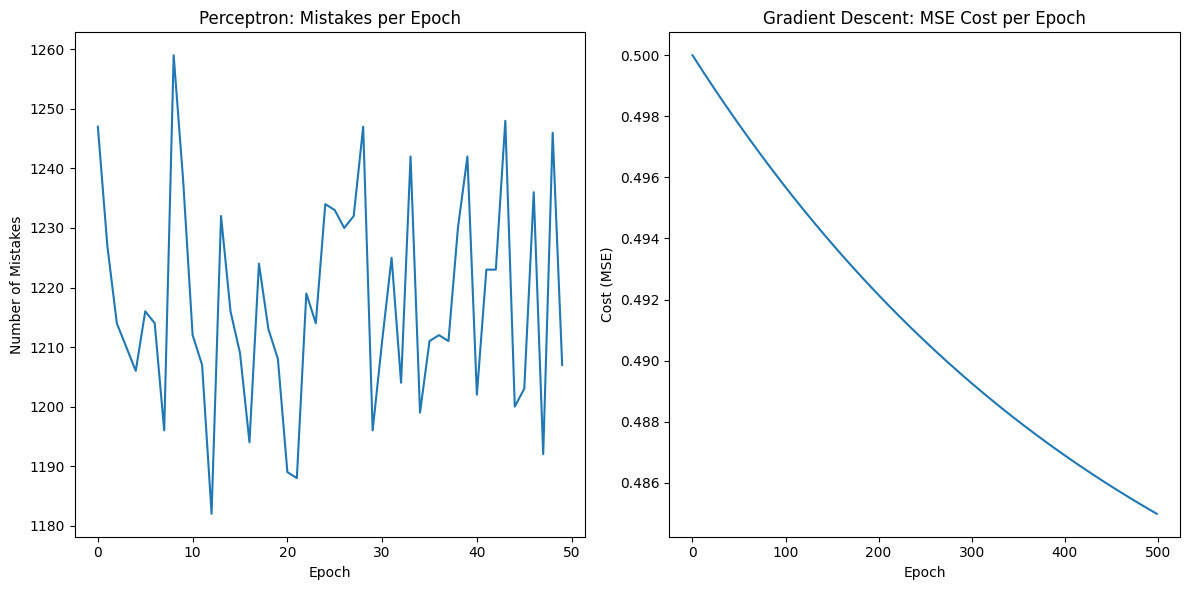


--- Test Accuracies ---
Perceptron Accuracy: 0.5015
Gradient Descent Accuracy: 0.6280
Margin Classifier Accuracy: 0.6280


In [11]:
from sklearn.metrics import accuracy_score

# Instantiate and train the Gradient Descent model
model_gd = GDWaterClassifier()
model_gd.fit(X_train, y_train)
print(f"Gradient Descent trained. Last cost: {model_gd.cost_history[-1]:.4f}")

# Instantiate and train the Margin Classifier model
model_margin = MarginWaterClassifier()
model_margin.fit(X_train, y_train)
print("Margin Classifier trained.")


# --- Evaluation and Plotting ---

# 1. Convergence Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(model_p.mistakes)
plt.title('Perceptron: Mistakes per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Number of Mistakes')

plt.subplot(1, 2, 2)
plt.plot(model_gd.cost_history)
plt.title('Gradient Descent: MSE Cost per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cost (MSE)')
plt.tight_layout()
plt.show()

# 2. Accuracy Report
y_pred_p = model_p.predict(X_test)
accuracy_p = accuracy_score(y_test, y_pred_p)

y_pred_gd = model_gd.predict(X_test)
accuracy_gd = accuracy_score(y_test, y_pred_gd)

y_pred_margin = model_margin.predict(X_test)
accuracy_margin = accuracy_score(y_test, y_pred_margin)

print(f"\n--- Test Accuracies ---")
print(f"Perceptron Accuracy: {accuracy_p:.4f}")
print(f"Gradient Descent Accuracy: {accuracy_gd:.4f}")
print(f"Margin Classifier Accuracy: {accuracy_margin:.4f}")


# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?
*Hint: Think about convergence, overshooting, and divergence.* <br>
A: If the learning rate is too high, the Gradient Descent model can 'overshoot' the minimum of the loss function. This can lead to oscillations, where the cost never settles, or even divergence, where the cost increases and the model fails to learn effectively.

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?
*Hint: Consider the mathematical formulation of the loss function (e.g., Hinge Loss) and symmetry.* <br>
A: Converting labels to {-1, 1} provides mathematical symmetry around zero, which is beneficial for loss functions like Hinge Loss and Perceptron. It simplifies calculations (e.g., y * prediction directly indicates correctness or mistake magnitude) and aligns better with geometric interpretations of decision boundaries.

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?
*Hint: Think about robustness to outliers and margin-based classifiers.*
<br>
A: The Margin Classifier (like a Support Vector Machine) is best suited for noisy, non-perfectly separable data. It focuses on finding a decision boundary with the largest possible margin, making it more robust to outliers and noise compared to the Perceptron or a basic Gradient Descent classifier.
